## Making figure 4 

Start by importing modules, data and defining functions.

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt
import numpyro.distributions as dist

from makeCorner import *

tmp_max = 100.
tmp_min = 2.

In [2]:
cdf_file = "../data/RUNS/power_law_only_high_sigmoids.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [3]:
def massModel_variation_all_m1(m1, alpha_ref, high_alpha, width_alpha, middle_alpha,
                               mu_m1, sig_m1, log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak,
                               mMax, high_mMax, width_mMax, middle_mMax,
                               mMin, high_mMin, width_mMin, middle_mMin,
                               dmMax, high_dmMax, width_dmMax, middle_dmMax,
                               dmMin, high_dmMin, width_dmMin, middle_dmMin, zs):
    
    alpha_new = sigmoid_no_delta(alpha_ref, high_alpha, width_alpha, middle_alpha, zs)
    p_m1_pl = (1.+alpha_new)*m1**(alpha_new)/(tmp_max**(1.+alpha_new) - tmp_min**(1.+alpha_new))

    p_m1_peak = jnp.exp(-(m1-mu_m1)**2/(2.*sig_m1**2))/jnp.sqrt(2.*np.pi*sig_m1**2)
    
    new_mMax = sigmoid_no_delta(mMax, high_mMax, width_mMax, middle_mMax, zs)
    new_dmMax = sigmoid_no_delta(dmMax, high_dmMax, width_dmMax, middle_dmMax, zs)
    new_mMin = sigmoid_no_delta(mMin, high_mMin, width_mMin, middle_mMin, zs)
    new_dmMin = sigmoid_no_delta(dmMin, high_dmMin, width_dmMin, middle_dmMin, zs)

    # Compute low- and high-mass filters
    low_filter = jnp.exp(-(m1-new_mMin)**2/(2.*new_dmMin**2))
    low_filter = jnp.where(m1<new_mMin,low_filter,1.)
    high_filter = jnp.exp(-(m1-new_mMax)**2/(2.*new_dmMax**2))
    high_filter = jnp.where(m1>new_mMax,high_filter,1.)

    new_f_peak = sigmoid_no_delta(log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, zs)
    actual_f_peak = 10.**(new_f_peak)
    combined_p = jnp.array((actual_f_peak*p_m1_peak + (1. - actual_f_peak)*p_m1_pl)*low_filter*high_filter)
    return combined_p

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

### Making the figure

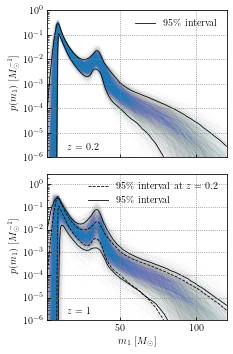

In [4]:
cm = 1/2.54
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8.5*cm, 2*6.375*cm))
m_grid = np.linspace(2,120,500)

ax1.set_rasterization_zorder(2)

pm_matrix = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))

for i in range(samps.alpha_ref.size):
    p_m = massModel_variation_all_m1(m_grid, samps.alpha_ref.values[i], samps.high_alpha.values[i],
                                     samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
                                     samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
                                     samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                     samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
                                     samps.mMin.values[i], samps.high_mMin.values[i], samps.width_mMin.values[i], samps.middle_z_mMin.values[i],
                                     10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i], samps.width_dmMax.values[i], samps.middle_z_dmMax.values[i],
                                     10.**samps.log_dmMin.values[i], 10.**samps.log_high_dmMin.values[i], samps.width_dmMin.values[i], samps.middle_z_dmMin.values[i], 0.2)
    p_m /= np.trapz(p_m,m_grid)
    pm_matrix[i, :] = p_m
    ax1.plot(m_grid,p_m,color='#1f78b4',lw=0.1,alpha=0.05, zorder = 1)
    
ax1.set_yscale('log')
ax1.set_ylim(1e-6,1)
ax1.set_ylabel(r"$p(m_1)$ $[M_\odot^{-1}]$", fontsize = 10)
ax1.text(15,2e-6,f"$z$ = 0.2")
ax1.tick_params(axis='y', labelsize=10)
ax1.plot(m_grid,np.quantile(pm_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1, label=r"95$\%$ interval")
ax1.plot(m_grid,np.quantile(pm_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1)

ax2.set_rasterization_zorder(2)

pm_matrix_axes_2 = np.zeros((len(range(samps.alpha_ref.size)), len(m_grid)))

for i in range(samps.alpha_ref.size):
    p_m = massModel_variation_all_m1(m_grid, samps.alpha_ref.values[i], samps.high_alpha.values[i],
                                     samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
                                     samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
                                     samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                     samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
                                     samps.mMin.values[i], samps.high_mMin.values[i], samps.width_mMin.values[i], samps.middle_z_mMin.values[i],
                                     10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i], samps.width_dmMax.values[i], samps.middle_z_dmMax.values[i],
                                     10.**samps.log_dmMin.values[i], 10.**samps.log_high_dmMin.values[i], samps.width_dmMin.values[i], samps.middle_z_dmMin.values[i], 1)
    p_m /= np.trapz(p_m,m_grid)
    pm_matrix_axes_2[i,:] = p_m
    ax2.plot(m_grid,p_m,color='#1f78b4',lw=0.1,alpha=0.05, zorder = 1)
    
ax2.set_yscale('log')
ax2.set_xlim(2,120)
ax2.set_ylim(1e-6,3)
ax2.set_xlabel(r"$m_1$ [$M_{\odot}$]", fontsize = 10)
ax2.set_ylabel(r"$p(m_1)$ $[M_\odot^{-1}]$", fontsize = 10)
ax2.text(15,2e-6,f"$z$ = 1")
plt.xticks(fontsize=10)
ax2.tick_params(axis='y', labelsize=10)
# plt.yticks(fontsize=10)
ax2.plot(m_grid,np.quantile(pm_matrix,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1,  linestyle='dashed', label=r'95$\%$ interval at $z$ = 0.2')
ax2.plot(m_grid,np.quantile(pm_matrix,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1,  linestyle='dashed')
ax2.plot(m_grid,np.quantile(pm_matrix_axes_2,0.05,axis=0), zorder = 1, color='k', lw=0.8, alpha=1, label=r' 95$\%$ interval')
ax2.plot(m_grid,np.quantile(pm_matrix_axes_2,0.95,axis=0), zorder = 1, color='k', lw=0.8, alpha=1)


plt.setp(ax1.get_xticklabels(), visible=False)

ax1.legend(loc='upper right', fontsize = 10)
ax2.legend(loc='upper right', fontsize = 10)

plt.tight_layout()
plt.savefig("p(m)_power_law_one_plot.pdf", dpi=500, bbox_inches="tight")
plt.show()